In [ ]:
# This notebook has been run on Google Colab. To run it, uncomment the following lines

# !rm -r Few-shot-learning-with-HuBERT
# !git clone https://github.com/luckyman94/Few-shot-learning-with-HuBERT.git

# !pip install -U kagglehub

# !rm -r kagglehub_cache/


rm: cannot remove 'Few-shot-learning-with-HuBERT': No such file or directory
Cloning into 'Few-shot-learning-with-HuBERT'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269 (from 1)
Receiving objects: 100% (269/269), 4.31 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (117/117), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.13
    Uninstalling kagglehub-0.3.13:
      Successfully uninstalled kagglehub-0.3.13
rm: cannot remove 'kagglehub_cache/': No such file or directory


In [ ]:
import os
import sys
from pathlib import Path
import torch

# ---- Hugging Face token ----
# Uncomment the following line if you want to run the notebook on Google Colab. Make sure to replace "YOUR
#os.environ["HF_TOKEN"] = "YOUR TOKEN HERE"

# Uncomment the following lines if you want to run the notebook on Google Colab
#ROOT = Path.cwd() / "Few-shot-learning-with-HuBERT"
#sys.path.append(str(ROOT))

assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))


from transformers import HubertModel
from src.datasets.speech_commands import SpeechCommandsDataset
from src.methods.fewshot.benchmark import benchmark_fewshot
from src.evaluation.evaluate import evaluate_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [23]:
dataset = SpeechCommandsDataset()

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))


Using Colab cache for faster access to the 'speech-commands' dataset.
[INFO] Building balanced dataset: 142 samples × 7 classes = 994
[INFO] Final dataset: 994 samples (142 per class)
Classes : ['down', 'left', 'off', 'on', 'right', 'stop', 'up']
Nombre total de fichiers : 994


In [24]:
X = []
y = []

for waveform, label in dataset:
    X.append(waveform)
    y.append(label)

X = torch.stack(X)
y = torch.tensor(y)


print(X.shape)
print(y.shape)


torch.Size([994, 16000])
torch.Size([994])


In [25]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [26]:
results = {}
for k in [1,5,10]:
    results[k] = benchmark_fewshot(model=hubert, X=X, y=y, device=device, k_shot=k, n_tasks=100)


10-shot benchmark: 100%|██████████| 100/100 [02:01<00:00,  1.22s/it]



===== Few-shot evaluation summary =====

--- 1-shot ---
Accuracy : 0.5576 ± 0.0989
F1 macro : 0.5569


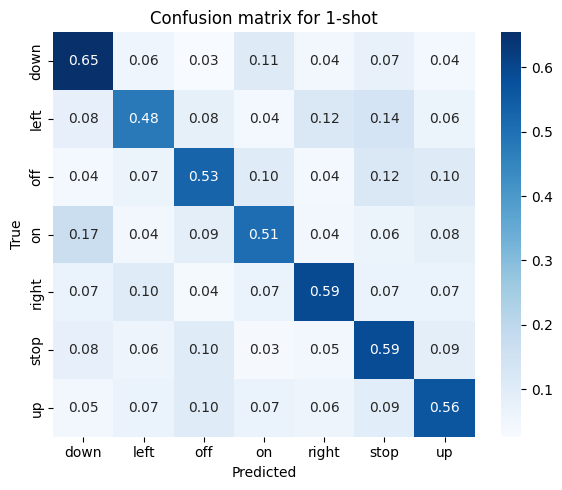


=== Evaluation metrics ===
accuracy    : 0.5576
f1_macro    : 0.5569
precision_macro: 0.5585
recall_macro: 0.5583


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


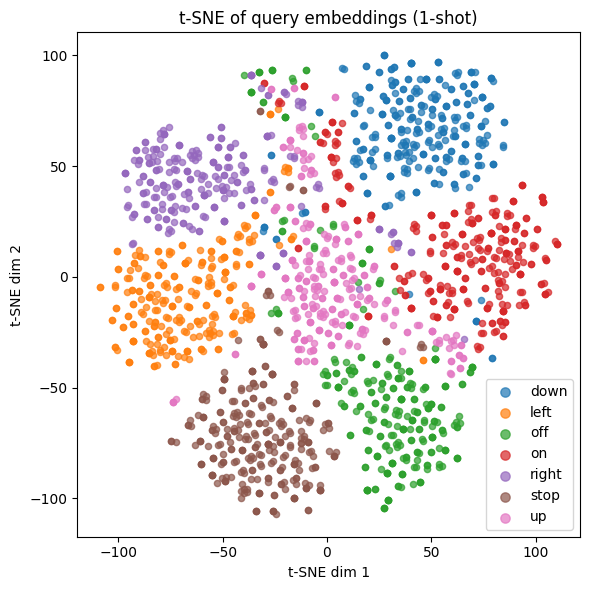


--- 5-shot ---
Accuracy : 0.8115 ± 0.0619
F1 macro : 0.8100


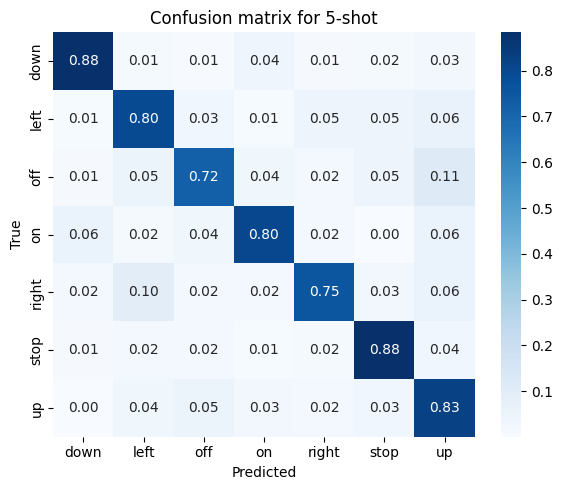


=== Evaluation metrics ===
accuracy    : 0.8115
f1_macro    : 0.8100
precision_macro: 0.8138
recall_macro: 0.8095


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


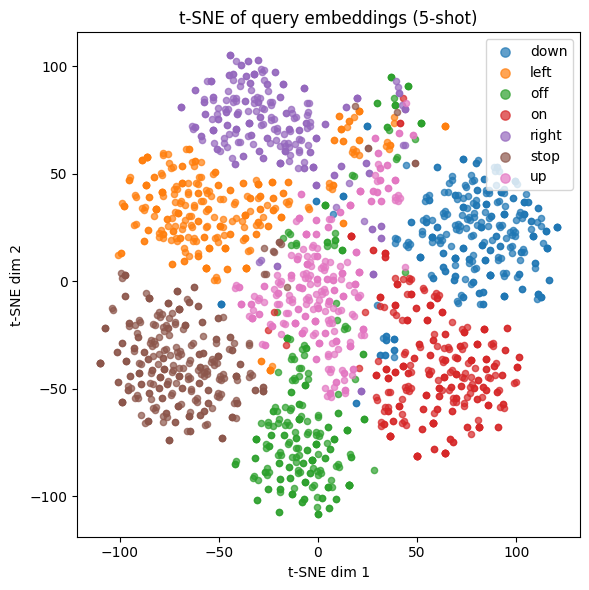


--- 10-shot ---
Accuracy : 0.8646 ± 0.0379
F1 macro : 0.8668


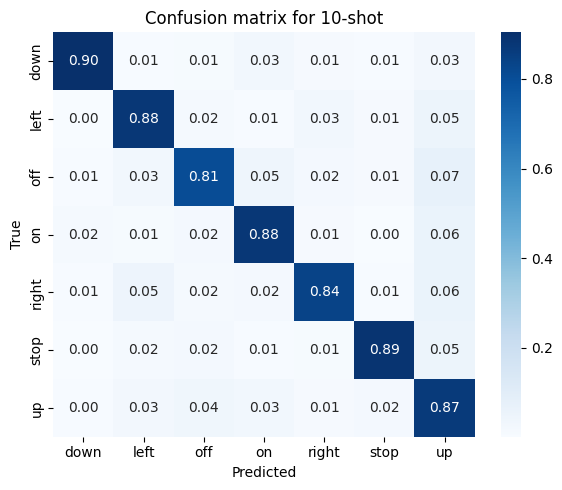


=== Evaluation metrics ===
accuracy    : 0.8646
f1_macro    : 0.8668
precision_macro: 0.8708
recall_macro: 0.8654


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


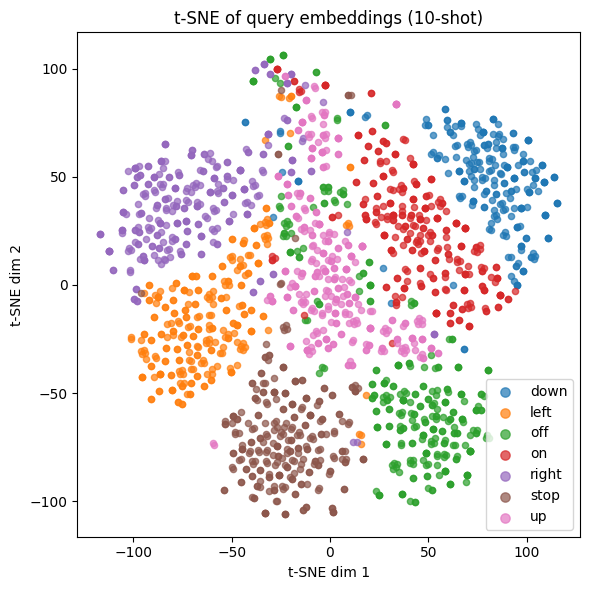

In [27]:
evaluate_benchmark(results, class_names=dataset.classes)